In [2]:
import os
import ast
from pprint import pprint
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import datetime as dt
import seaborn as sns
import swifter
from collections import namedtuple
# %config InlineBackend.figure_format = 'retina'  # 提高 jupyter notebook 的圖形顯示解析度

# Find Files

In [3]:
root = '/home/wmnlab/D/database'
root = '/Users/jackbedford/Desktop/MOXA/Code/data'
paths = [s for s in os.listdir(root) if s.startswith('202') and os.path.isdir(os.path.join(root, s))]

md_files = []

for date_dir in paths:
    datedir = os.path.join(root, date_dir)
    md_file = [os.path.join(datedir, s) for s in os.listdir(datedir) if s.endswith('.md')]
    md_files += md_file

md_files = sorted(md_files)

# Select dates
# md_files = md_files[:-1]
# md_files = [md_files[2]]

pprint(md_files)

['/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/2023-03-16.md',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-26/2023-03-26.md',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/2023-04-01.md',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-10/2023-04-10.md',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-17/2023-04-17.md',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-04/2023-05-04.md',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-07/2023-05-07.md',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-15/2023-05-15.md',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-24/2023-05-24.md',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-26/2023-05-26.md',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-06-12/2023-06-12.md',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-06-13/2023-06-13.md',
 '/Users/jackbedford/Desktop/MOXA/Code/data/2023-06-15/2023-06-15.md']


In [4]:
class Experiment():
    
    def __init__(self, dir_name, setting):
        
        self.dir_name = dir_name
        self.setting = setting
        
    def __repr__(self):
        return f'{self.dir_name} -> {self.setting}'

exp_list = []

for md_file in md_files:
    
    md_f = open(md_file, 'r')
    lines = []
    l = md_f.readline()[:-1]
    
    while l:
        
        if l == '#endif':
            break
        lines.append(l)
        l = md_f.readline()[:-1]
        
    md_f.close()
    
    for exp, dic in zip(lines[::2], lines[1::2]):
        
        dictionary = ast.literal_eval(dic)
        parent_dir = os.path.dirname(md_file)
        experiment = Experiment(dir_name = os.path.join(parent_dir, exp), setting=dictionary)
        exp_list.append(experiment)
        
pprint(exp_list)

[/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q -> {'qc00': 'B1', 'qc02': 'B7', 'qc03': 'B8'},
 /Users/jackbedford/Desktop/MOXA/Code/data/2023-03-26/Bandlock_Udp_All_RM500Q -> {'qc00': 'B3', 'qc02': 'B7', 'qc03': 'B8'},
 /Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q -> {'qc00': 'B1B3', 'qc01': 'B1B8', 'qc02': 'LTE', 'qc03': 'All'},
 /Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/Bandlock_Udp_B1_B3_B7_B8_RM500Q -> {'qc00': 'B1', 'qc01': 'B3', 'qc02': 'B7', 'qc03': 'B8'},
 /Users/jackbedford/Desktop/MOXA/Code/data/2023-04-10/Experiment1 -> {'qc00': 'All', 'qc01': 'All', 'qc02': 'All', 'qc03': 'All'},
 /Users/jackbedford/Desktop/MOXA/Code/data/2023-04-10/Experiment2 -> {'qc00': 'B1', 'qc01': 'B3', 'qc02': 'B7', 'qc03': 'B8'},
 /Users/jackbedford/Desktop/MOXA/Code/data/2023-04-10/Experiment3 -> {'qc00': 'LTE', 'qc01': 'All', 'qc02': 'B7B8', 'qc03': 'B7'},
 /Users/jackbedford/Desktop/MOXA/Code/data/2023

In [5]:
# Set band parameters
schms = ['All','LTE','B1','B3', 'B7', 'B8']

rrc_dict = {}
nr_dict = {}
lte_dict = {}
ul_pkt_dict = {}
dl_pkt_dict = {}
ul_sta_dict = {}
dl_sta_dict = {}

for schm in schms:
        
    path_list = []
    
    for exp in exp_list:
        
        reverse_dict = {v:k for k, v in exp.setting.items()}
        
        try:
            dev = reverse_dict[schm]
        except:
            # print('warning:', schm)
            continue
        
        device_dir = os.path.join(exp.dir_name, dev)
        
        for trace in os.listdir(device_dir):
        
            if '#' not in trace:
                continue
        
            trace_dir = os.path.join(device_dir, trace, 'data')
            path_list.append(trace_dir)

    path_list = sorted(path_list)

    rrc_list, nr_list, lte_list, ul_pkt_list, dl_pkt_list = [], [], [], [], []
    ul_sta_list, dl_sta_list = [], []

    for path in path_list:
        
        rrc_list += [os.path.join(path, s) for s in os.listdir(path) if s.endswith('_rrc.csv')]
        nr_list += [os.path.join(path, s) for s in os.listdir(path) if s.endswith('_nr_ml1.csv')]
        lte_list += [os.path.join(path, s) for s in os.listdir(path) if s.endswith('_ml1.csv') and not s.endswith('_nr_ml1.csv')]
        ul_pkt_list += [os.path.join(path, 'udp_uplk_loss_latency.csv')]
        dl_pkt_list += [os.path.join(path, 'udp_dnlk_loss_latency.csv')]
        ul_sta_list += [os.path.join(path, 'udp_uplk_combo_statistics.csv')]
        dl_sta_list += [os.path.join(path, 'udp_dnlk_combo_statistics.csv')]
    
    rrc_dict[schm] = rrc_list
    nr_dict[schm] = nr_list
    lte_dict[schm] = lte_list
    ul_pkt_dict[schm] = ul_pkt_list
    dl_pkt_dict[schm] = dl_pkt_list
    ul_sta_dict[schm] = ul_sta_list
    dl_sta_dict[schm] = dl_sta_list

# rrc_dict['All'] = rrc_dict['All'] + rrc_dict['B3B7B8']
# nr_dict['All'] = nr_dict['All'] + nr_dict['B3B7B8']
# lte_dict['All'] = lte_dict['All'] + lte_dict['B3B7B8']
# ul_pkt_dict['All'] = ul_pkt_dict['All'] + ul_pkt_dict['B3B7B8']
# dl_pkt_dict['All'] = dl_pkt_dict['All'] + dl_pkt_dict['B3B7B8']

# schms.remove('B3B7B8')

In [7]:
p = '/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-17/Bandlock_Udp_All_LTE_All_LTE_RM500Q/combo'

UL = []
DL = []

# for p1 in sorted([os.path.join(p, p_) for p_ in os.listdir(p)]):

#     UL.append(os.path.join(p1, 'udp_uplk_combo_statistics.csv'))
#     DL.append(os.path.join(p1, 'udp_dnlk_combo_statistics.csv'))

p = '/home/wmnlab/D/database/2023-06-24/Modem_Action_Test/combo'

for p1 in sorted([os.path.join(p, p_) for p_ in os.listdir(p)]):

    UL.append(os.path.join(p1, 'udp_uplk_combo_statistics.csv'))
    DL.append(os.path.join(p1, 'udp_dnlk_combo_statistics.csv'))

    if '#06' in p1:
        break

DL

FileNotFoundError: [Errno 2] No such file or directory: '/home/wmnlab/D/database/2023-06-24/Modem_Action_Test/combo'

In [50]:
dl_loss1 = []
dl_exc_lat1 = []
ul_loss1 = []
ul_exc_lat1 = []

for dl_target_file, ul_target_file in zip(DL, UL):
    
    if '04-17' in dl_target_file:
        df = pd.read_csv(dl_target_file)
        a = df['lost_All0+All2'].iloc[0]
        b = df['excl_All0+All2'].iloc[0]
        c = df['latency_All0+All2'].iloc[0]
        dl_loss1.append(a), dl_exc_lat1.append(b)
        print('dl',a,b,c)
        
        df = pd.read_csv(ul_target_file)
        a = df['lost_All0+All2'].iloc[0]
        b = df['excl_All0+All2'].iloc[0]
        c = df['latency_All0+All2'].iloc[0]
        ul_loss1.append(a), ul_exc_lat1.append(b)
        print('ul',a,b,c)
    elif '06-24' in dl_target_file:
        df = pd.read_csv(dl_target_file)
        a = df['lost_radio1+radio2'].iloc[0]
        b = df['excl_radio1+radio2'].iloc[0]
        c = df['latency_radio1+radio2'].iloc[0]
        dl_loss1.append(a), dl_exc_lat1.append(b)
        print(a,b,c)
        
        df = pd.read_csv(ul_target_file)
        a = df['lost_radio1+radio2'].iloc[0]
        b = df['excl_radio1+radio2'].iloc[0]
        c = df['latency_radio1+radio2'].iloc[0]
        ul_loss1.append(a), ul_exc_lat1.append(b)
        print(a,b,c)

0.0 0.011 0.006764
0.013 0.0 0.010004
0.598 0.046 0.007023
0.03 0.555 0.012069
0.0 0.0 0.006385
0.0 0.0 0.010244
0.0 0.059 0.006933
0.0 0.031 0.010268
0.0 0.061 0.006751
0.0 0.001 0.010471
0.0 0.005 0.007449
0.001 0.001 0.009699


In [57]:
dl_loss1, ul_loss1

([0.0, 0.598, 0.0, 0.0, 0.0, 0.0], [0.013, 0.03, 0.0, 0.0, 0.0, 0.001])

In [59]:
p = '/home/wmnlab/D/database/2023-06-21/Modem_Action_Test/combo'

UL = []
DL = []

# for p1 in sorted([os.path.join(p, p_) for p_ in os.listdir(p)]):

#     UL.append(os.path.join(p1, 'udp_uplk_combo_statistics.csv'))
#     DL.append(os.path.join(p1, 'udp_dnlk_combo_statistics.csv'))

p = '/home/wmnlab/D/database/2023-06-24/Modem_Action_Test/combo'

for p1 in sorted([os.path.join(p, p_) for p_ in os.listdir(p)]):

    cont = False
    for trace in [f'#0{x}' for x in range(1,7)]:
        if trace in p1:
            cont = True
            break

    if cont:
        continue
    
    UL.append(os.path.join(p1, 'udp_uplk_combo_statistics.csv'))
    DL.append(os.path.join(p1, 'udp_dnlk_combo_statistics.csv'))

DL

['/home/wmnlab/D/database/2023-06-24/Modem_Action_Test/combo/#07/udp_dnlk_combo_statistics.csv',
 '/home/wmnlab/D/database/2023-06-24/Modem_Action_Test/combo/#08/udp_dnlk_combo_statistics.csv',
 '/home/wmnlab/D/database/2023-06-24/Modem_Action_Test/combo/#09/udp_dnlk_combo_statistics.csv',
 '/home/wmnlab/D/database/2023-06-24/Modem_Action_Test/combo/#10/udp_dnlk_combo_statistics.csv',
 '/home/wmnlab/D/database/2023-06-24/Modem_Action_Test/combo/#11/udp_dnlk_combo_statistics.csv']

In [60]:
dl_loss2 = []
dl_exc_lat2 = []
ul_loss2 = []
ul_exc_lat2 = []

for dl_target_file, ul_target_file in zip(DL, UL):
    
    df = pd.read_csv(dl_target_file)
    a = df['lost_radio1+radio2'].iloc[0]
    b = df['excl_radio1+radio2'].iloc[0]
    c = df['latency_radio1+radio2'].iloc[0]
    dl_loss2.append(a), dl_exc_lat2.append(b)
    print(a,b,c)
    
    df = pd.read_csv(ul_target_file)
    a = df['lost_radio1+radio2'].iloc[0]
    b = df['excl_radio1+radio2'].iloc[0]
    c = df['latency_radio1+radio2'].iloc[0]
    ul_loss2.append(a), ul_exc_lat2.append(b)
    print(a,b,c)

0.0 0.0 0.006658
0.001 0.0 0.009761
0.0 0.0 0.006486
0.003 0.001 0.010277
0.142 0.019 0.006376
0.001 1.765 0.017061
0.0 0.0 0.006433
0.171 0.001 0.010429
0.0 0.0 0.007158
0.001 0.001 0.009693


In [61]:
dl_loss2, ul_loss2

([0.0, 0.0, 0.142, 0.0, 0.0], [0.001, 0.003, 0.001, 0.171, 0.001])

# Functions

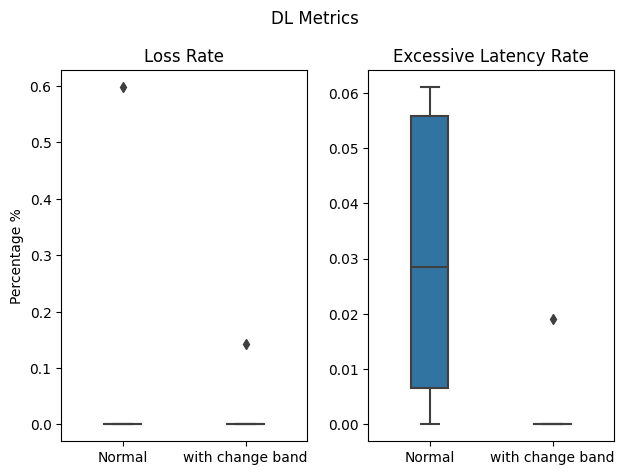

In [62]:
fig, axes = plt.subplots(1,2)
name = ['Normal', 'With Change Band']

plt.suptitle('DL Metrics')

sns.boxplot(data=[dl_loss1, dl_loss2], width=0.3, ax=axes[0])
axes[0].set_title('Loss Rate')
axes[0].set_xticklabels(['Normal', 'with change band'])
axes[0].set_ylabel('Percentage %')

sns.boxplot(data=[dl_exc_lat1, dl_exc_lat2], width=0.3, ax=axes[1])
axes[1].set_title('Excessive Latency Rate')
axes[1].set_xticklabels(['Normal', 'with change band'])
plt.tight_layout()

plt.show()

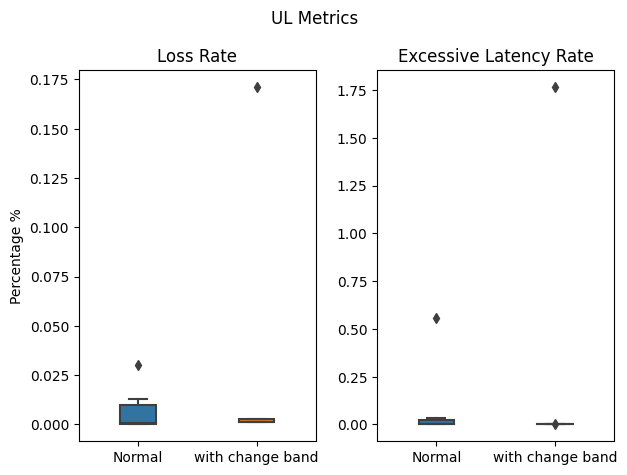

In [63]:
fig, axes = plt.subplots(1,2)
name = ['Normal', 'With Change Band']

plt.suptitle('UL Metrics')

sns.boxplot(data=[ul_loss1, ul_loss2], width=0.3, ax=axes[0])
axes[0].set_title('Loss Rate')
axes[0].set_xticklabels(['Normal', 'with change band'])
axes[0].set_ylabel('Percentage %')

sns.boxplot(data=[ul_exc_lat1, ul_exc_lat2], width=0.3, ax=axes[1])
axes[1].set_title('Excessive Latency Rate')
axes[1].set_xticklabels(['Normal', 'with change band'])
plt.tight_layout()

plt.show()

# HO analysis

In [ ]:
def parse_mi_ho(f):

    df = pd.read_csv(f)
    df["Timestamp"] = df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x) + dt.timedelta(hours=8))
    nr_pci = ''

    def NR_OTA():
        if df["type_id"].iloc[i] == "5G_NR_RRC_OTA_Packet":
            return True
        else:
            return False

    def find_1st_after(target, look_after=1):
        for j in range(i, len(df)):
            t_ = df["Timestamp"].iloc[j]
            if (t_ - t).total_seconds() > look_after:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before(target, look_before=1):
        for j in range(i, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    HO = namedtuple('HO','start, end, others', defaults=(None,None))

    D = {
        'Conn_Rel':[], 
        'Conn_Req':[], # Setup
        'LTE_HO': [], # LTE -> newLTE
        'MN_HO': [], # LTE + NR -> newLTE + NR
        'MN_HO_to_eNB': [], # LTE + NR -> newLTE
        'SN_setup': [], # LTE -> LTE + NR => NR setup
        'SN_Rel': [], # LTE + NR -> LTE
        'SN_HO': [], # LTE + NR -> LTE + newNR
        'RLF_II': [],
        'RLF_III': [],
        'SCG_RLF': [],
        }

    for i in range(len(df)):
        if NR_OTA():
            continue

        t = df["Timestamp"].iloc[i]
        
        others = ''
        if df["rrcConnectionRelease"].iloc[i] == 1:
            D['Conn_Rel'].append(HO(start=t))

        if df["rrcConnectionRequest"].iloc[i] == 1:
            
            a = find_1st_after('rrcConnectionReconfigurationComplete',look_after=2)[0]
            b = find_1st_after('securityModeComplete',look_after=2)[0]
            if a is None and b is None: end = None
            elif a is None and b is not None: end = b
            elif a is not None and b is None: end = a 
            else: end = a if a > b else b
            
            D['Conn_Req'].append(HO(start=t,end=end))
            nr_pci = ''
        
        if df["lte-rrc.t304"].iloc[i] == 1:
            end, _ = find_1st_after('rrcConnectionReconfigurationComplete')
            serv_cell, target_cell = df["PCI"].iloc[i], df['lte_targetPhysCellId'].iloc[i]
            serv_freq, target_freq = df["Freq"].iloc[i], df['dl-CarrierFreq'].iloc[i]

            if df["SCellToAddMod-r10"].iloc[i] == 1:
                n =len(str(df["SCellIndex-r10.1"].iloc[i]).split('@'))
                others=f'Set up {n} SCell.'
            
            if serv_freq != target_freq:
                a,b = find_1st_before("rrcConnectionReestablishmentRequest", 1)
                others += " Inter freq. HO."
                if a is not None:
                    others += " Near after RLF."
                
            if df["nr-rrc.t304"].iloc[i] == 1 and df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:
                
                if serv_cell == target_cell and serv_freq == target_freq:
                    D['SN_setup'].append(HO(start=t, end=end, others=others))
                    nr_pci = df['nr_physCellId'].iloc[i]
                else:    
                    D['MN_HO'].append(HO(start=t, end=end, others=others))
                    nr_pci = df['nr_physCellId'].iloc[i]
            else:
                
                if serv_cell == target_cell and serv_freq == target_freq:
                    a, b = find_1st_before("scgFailureInformationNR-r15")
                    if a is not None:
                        others += " Caused by scg-failure."
                    D['SN_Rel'].append(HO(start=t, end=end, others=others))
                    nr_pci = ''
                else:
                    a, b = find_1st_before("rrcConnectionSetup",3)
                    if a is not None:
                        others += 'Near After connection setup'
                    if nr_pci == '':
                        D['LTE_HO'].append(HO(start=t, end=end, others=others))
                    else:
                        D['MN_HO_to_eNB'].append(HO(start=t, end=end, others=others))

        if df["nr-rrc.t304"].iloc[i] == 1 and not df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:
            end, _ = find_1st_after('rrcConnectionReconfigurationComplete')
            D['SN_HO'].append(HO(start=t,end=end))
            nr_pci = df['nr_physCellId'].iloc[i]

        if df["rrcConnectionReestablishmentRequest"].iloc[i] == 1:
            end, _ = find_1st_after('rrcConnectionReestablishmentComplete', look_after=1)
            b, _ = find_1st_after('rrcConnectionReestablishmentReject', look_after=1)
            others = df["reestablishmentCause"].iloc[i]
            c, d = find_1st_before('scgFailureInformationNR-r15', 1)
            if c != None:
                others  += ' caused by scgfailure.'
            if end is not None: 
                # Type II
                D['RLF_II'].append(HO(start=t,end=end,others=others))
            else: 
                # Type III
                D['RLF_III'].append(HO(start=t,end=b,others=others)) # End for Type III?
            
        if df["scgFailureInformationNR-r15"].iloc[i] == 1:
            others = df["failureType-r15"].iloc[i]
            D['SCG_RLF'].append(HO(start=t,others=others))
    
    return D

In [ ]:
p1 = '/home/wmnlab/D/database/2023-06-21/Modem_Action_Test/qc00'
p2 = '/home/wmnlab/D/database/2023-06-21/Modem_Action_Test/qc03'
p3 = '/home/wmnlab/D/database/2023-04-17/Bandlock_Udp_All_LTE_All_LTE_RM500Q/qc00'
p4 = '/home/wmnlab/D/database/2023-04-17/Bandlock_Udp_All_LTE_All_LTE_RM500Q/qc02'

rrc1 = []
rrc2 = []
rrc3 = []
rrc4 = []

for p11 in [os.path.join(p1, p_) for p_ in os.listdir(p1)]:

    if 'combo' in p11:
        continue

    data_dir = os.path.join(p11, 'data')

    rrc1 += [os.path.join(data_dir, s) for s in os.listdir(data_dir) if s.endswith('_rrc.csv')]

for p11 in [os.path.join(p2, p_) for p_ in os.listdir(p2)]:

    if 'combo' in p11:
        continue

    data_dir = os.path.join(p11, 'data')

    rrc2 += [os.path.join(data_dir, s) for s in os.listdir(data_dir) if s.endswith('_rrc.csv')]

for p11 in [os.path.join(p3, p_) for p_ in os.listdir(p3)]:

    if 'combo' in p11:
        continue

    data_dir = os.path.join(p11, 'data')

    rrc3 += [os.path.join(data_dir, s) for s in os.listdir(data_dir) if s.endswith('_rrc.csv')]

for p11 in [os.path.join(p4, p_) for p_ in os.listdir(p4)]:

    if 'combo' in p11:
        continue

    data_dir = os.path.join(p11, 'data')

    rrc4 += [os.path.join(data_dir, s) for s in os.listdir(data_dir) if s.endswith('_rrc.csv')]

rrc1.sort()
rrc2.sort()
rrc3.sort()
rrc4.sort()

pprint(rrc1)
pprint(rrc2)
pprint(rrc3)
pprint(rrc4)

In [ ]:
for f in rrc4:

    evts = parse_mi_ho(f)

    for k, v in evts.items():

        print(f'{k}: {len(v)}')

    print('============')

In [ ]:
for f in rrc1:

    evts = parse_mi_ho(f)

    for k, v in evts.items():

        print(f'{k}: {len(v)}')

    print('============')

In [ ]:
for f in rrc2:

    evts = parse_mi_ho(f)

    for k, v in evts.items():

        print(f'{k}: {len(v)}')

    print(evts)
    print('============')

In [ ]:
evts

In [ ]:
evts2